In [2]:
import numpy as np
import pandas as pd
import re
from pathlib import Path

In [3]:
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
in_path = Path('../data/raw')
out_path = Path('../data/interim')

In [5]:
df = pd.read_csv(in_path / 'properties_cleaned_v1.csv')

In [6]:
df.shape

(5933, 18)

In [7]:
df.duplicated().sum()

0

In [8]:
df.head(1)
# focus is on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id
0,flat,olive greens,gota,0.9,9313.0,966.0,Super Built up area 1918(178.19 sq.m.)Built Up...,3,3,1,store room,3.0,East,1 to 5 Year Old,"['Fraucow Shopping Mall', 'S G Business Hub', ...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",L63689388


## 1. areaWithType

In [9]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
1957,0.95,1665.0,Built Up area: 1665 (154.68 sq.m.)Carpet area:...
2687,0.63,1295.0,Super Built up area 1500(139.35 sq.m.)
1305,0.62,843.0,Carpet area: 843 (78.32 sq.m.)
5530,0.19,612.0,Super Built up area 68(56.86 sq.m.)
3658,1.23,2398.0,Built Up area: 2398 (222.78 sq.m.)


In [10]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [11]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [12]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [13]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [14]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
4975,0.85,house,1250.0,Built Up area: 1250 (116.13 sq.m.),NaN,1250.0,NaN
2223,0.60,flat,1305.0,Built Up area: 145 (121.24 sq.m.),NaN,145.0,NaN
964,2.50,house,1386.0,Plot area 154(128.76 sq.m.)Built Up area: 220 ...,NaN,220.0,NaN
5297,1.77,flat,2360.0,Super Built up area 2360(219.25 sq.m.),2360.0,NaN,NaN
5687,3.01,flat,4013.0,Super Built up area 4022(373.66 sq.m.),4022.0,NaN,NaN


In [15]:
df.duplicated().sum()

0

In [16]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(652, 7)

In [17]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1,6.40,house,3988.0,Plot area 450(376.26 sq.m.)Built Up area: 600 ...,NaN,600.0,NaN
4,2.30,house,2412.0,Plot area 268(224.08 sq.m.),NaN,NaN,NaN
8,3.25,house,2313.0,Plot area 257(214.88 sq.m.),NaN,NaN,NaN
10,2.35,house,240.0,Plot area 240(22.3 sq.m.),NaN,NaN,NaN
13,0.95,house,1200.0,Plot area 1200(111.48 sq.m.),NaN,NaN,NaN


In [18]:
df.isnull().sum()

property_type             0
society                   0
sector                    0
price                    11
price_per_sqft           12
area                     12
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 37
facing                 1678
agePossession             0
nearbyLocations         449
furnishDetails         2614
features               1244
property_id               0
super_built_up_area    3414
built_up_area          3925
carpet_area            2520
dtype: int64

In [19]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [20]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
4,2.30,house,2412.0,Plot area 268(224.08 sq.m.),NaN,NaN,NaN
8,3.25,house,2313.0,Plot area 257(214.88 sq.m.),NaN,NaN,NaN
10,2.35,house,240.0,Plot area 240(22.3 sq.m.),NaN,NaN,NaN
13,0.95,house,1200.0,Plot area 1200(111.48 sq.m.),NaN,NaN,NaN
14,0.50,house,1000.0,Plot area 1000(92.9 sq.m.),NaN,NaN,NaN


In [21]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [22]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [23]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [24]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
4,2.30,house,2412.0,Plot area 268(224.08 sq.m.),NaN,268.00,NaN
8,3.25,house,2313.0,Plot area 257(214.88 sq.m.),NaN,257.00,NaN
10,2.35,house,240.0,Plot area 240(22.3 sq.m.),NaN,240.00,NaN
13,0.95,house,1200.0,Plot area 1200(111.48 sq.m.),NaN,1200.00,NaN
14,0.50,house,1000.0,Plot area 1000(92.9 sq.m.),NaN,1000.00,NaN
24,0.47,house,1152.0,Plot area 107,NaN,107.00,NaN
35,0.90,house,1215.0,Plot area 135(112.88 sq.m.),NaN,135.00,NaN
76,4.25,house,3600.0,Plot area 400(334.45 sq.m.),NaN,400.00,NaN
85,1.50,house,900.0,Plot area 900(83.61 sq.m.),NaN,900.00,NaN
88,0.60,house,1280.0,Plot area 142.26(118.95 sq.m.),NaN,142.26,NaN


In [25]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [26]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [27]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
4,2.30,house,2412.0,Plot area 268(224.08 sq.m.),NaN,2412.000,NaN
8,3.25,house,2313.0,Plot area 257(214.88 sq.m.),NaN,2313.000,NaN
10,2.35,house,240.0,Plot area 240(22.3 sq.m.),NaN,240.000,NaN
13,0.95,house,1200.0,Plot area 1200(111.48 sq.m.),NaN,1200.000,NaN
14,0.50,house,1000.0,Plot area 1000(92.9 sq.m.),NaN,1000.000,NaN
24,0.47,house,1152.0,Plot area 107,NaN,1144.900,NaN
35,0.90,house,1215.0,Plot area 135(112.88 sq.m.),NaN,1215.000,NaN
76,4.25,house,3600.0,Plot area 400(334.45 sq.m.),NaN,3600.000,NaN
85,1.50,house,900.0,Plot area 900(83.61 sq.m.),NaN,900.000,NaN
88,0.60,house,1280.0,Plot area 142.26(118.95 sq.m.),NaN,1280.340,NaN


In [28]:
# update the original dataframe
df.update(all_nan_df)

In [29]:
df.isnull().sum()

property_type             0
society                   0
sector                    0
price                    11
price_per_sqft           12
area                     12
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 37
facing                 1678
agePossession             0
nearbyLocations         449
furnishDetails         2614
features               1244
property_id               0
super_built_up_area    3414
built_up_area          3409
carpet_area            2520
dtype: int64

In [30]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_built_up_area,built_up_area,carpet_area
0,flat,olive greens,gota,0.90,9313.0,966.0,Super Built up area 1918(178.19 sq.m.)Built Up...,3,3,1,store room,3.0,East,1 to 5 Year Old,"['Fraucow Shopping Mall', 'S G Business Hub', ...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",L63689388,1918.0,1005.0,967.9
1,house,aamramanjari bunglows,south bopal,6.40,16049.0,3988.0,Plot area 450(376.26 sq.m.)Built Up area: 600 ...,5,5,2,not available,1.0,East,1 to 5 Year Old,"['Icici ATM', 'State bank of india sbi ATM', '...","['1 Water Purifier', '5 Fan', '1 Dining Table'...","['Security / Fire Alarm', 'Water Storage', 'Vi...",C69028840,NaN,600.0,NaN
2,flat,avirat silver gardenia,gota,0.62,7607.0,815.0,Super Built up area 1359(126.26 sq.m.)Carpet a...,2,2,1,store room,2.0,East,1 to 5 Year Old,"['CHANDLODIA MARKET', 'Bhagwat Vidyapeeth', 'v...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",C70043520,1359.0,NaN,815.0
3,flat,preet residency,memnagar,0.85,5666.0,1500.0,Super Built up area 1500(139.35 sq.m.)Carpet a...,3,3,1,store room,4.0,NaN,10+ Year Old,"['Manav Mandir', 'ambe mataa mandir', 'Axis ba...","['1 Water Purifier', '6 Fan', '1 Fridge', '1 D...","['Lift(s)', 'Maintenance Staff', 'Security Per...",I69907630,1500.0,NaN,1250.0
4,house,independent,south bopal,2.30,9536.0,2412.0,Plot area 268(224.08 sq.m.),3,3,1,store room,1.0,NaN,5 to 10 Year Old,"['State bank of india sbi ATM', 'Icici ATM', '...","['1 Fridge', '1 Dining Table', '1 Modular Kitc...","['Private Garden / Terrace', 'Waste Disposal']",C70391696,NaN,2412.0,NaN


## 2.additionalRoom

In [31]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                           2706
store room                                               832
others                                                   448
pooja room                                               295
pooja room,study room,store room                         227
pooja room,store room                                    224
pooja room,store room,study room                         181
pooja room,study room,servant room,store room            118
pooja room,study room                                    113
store room,pooja room                                    101
study room                                                70
pooja room,others                                         59
pooja room,study room,servant room,others                 55
pooja room,study room,servant room                        53
pooja room,study room,others                              42
servant room                                              40
pooja roo

In [32]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [33]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
1173,not available,0,0,0,0,0
1680,not available,0,0,0,0,0
5206,"pooja room,others",0,0,0,1,1
4639,not available,0,0,0,0,0
584,store room,0,0,1,0,0


In [34]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,olive greens,gota,0.90,9313.0,966.0,Super Built up area 1918(178.19 sq.m.)Built Up...,3,3,1,store room,3.0,East,1 to 5 Year Old,"['Fraucow Shopping Mall', 'S G Business Hub', ...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",L63689388,1918.0,1005.0,967.9,0,0,1,0,0
1,house,aamramanjari bunglows,south bopal,6.40,16049.0,3988.0,Plot area 450(376.26 sq.m.)Built Up area: 600 ...,5,5,2,not available,1.0,East,1 to 5 Year Old,"['Icici ATM', 'State bank of india sbi ATM', '...","['1 Water Purifier', '5 Fan', '1 Dining Table'...","['Security / Fire Alarm', 'Water Storage', 'Vi...",C69028840,NaN,600.0,NaN,0,0,0,0,0
2,flat,avirat silver gardenia,gota,0.62,7607.0,815.0,Super Built up area 1359(126.26 sq.m.)Carpet a...,2,2,1,store room,2.0,East,1 to 5 Year Old,"['CHANDLODIA MARKET', 'Bhagwat Vidyapeeth', 'v...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",C70043520,1359.0,NaN,815.0,0,0,1,0,0
3,flat,preet residency,memnagar,0.85,5666.0,1500.0,Super Built up area 1500(139.35 sq.m.)Carpet a...,3,3,1,store room,4.0,NaN,10+ Year Old,"['Manav Mandir', 'ambe mataa mandir', 'Axis ba...","['1 Water Purifier', '6 Fan', '1 Fridge', '1 D...","['Lift(s)', 'Maintenance Staff', 'Security Per...",I69907630,1500.0,NaN,1250.0,0,0,1,0,0
4,house,independent,south bopal,2.30,9536.0,2412.0,Plot area 268(224.08 sq.m.),3,3,1,store room,1.0,NaN,5 to 10 Year Old,"['State bank of india sbi ATM', 'Icici ATM', '...","['1 Fridge', '1 Dining Table', '1 Modular Kitc...","['Private Garden / Terrace', 'Waste Disposal']",C70391696,NaN,2412.0,NaN,0,0,1,0,0


## 3.agePossession

In [35]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1814
5 to 10 Year Old      1280
10+ Year Old          1076
undefined              507
0 to 1 Year Old        481
Dec 2025               127
Dec 2024               111
Dec 2026                71
Under Construction      59
Mar 2025                49
Dec 2023                42
Within 6 months         32
Mar 2024                32
Within 3 months         23
By 2024                 16
Jun 2025                12
Jun 2024                10
Dec 2027                10
By 2023                  9
Mar 2026                 9
Dec-25                   9
May 2025                 9
Jun 2026                 9
Jul 2026                 7
By 2025                  7
Jul 2024                 7
By 2026                  7
Jan 2025                 6
Dec-24                   6
Jul-24                   6
Apr 2024                 5
Oct 2025                 5
Nov 2027                 5
May 2024                 4
Apr 2025                 4
Nov 2026                 4
Sep 2023      

In [36]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [37]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [38]:
df['agePossession'].value_counts()

agePossession
Relatively New        1814
Moderately Old        1280
Old Property          1076
Under Construction     675
Undefined              552
New Property           536
Name: count, dtype: int64

In [39]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,olive greens,gota,0.90,9313.0,966.0,Super Built up area 1918(178.19 sq.m.)Built Up...,3,3,1,store room,3.0,East,Relatively New,"['Fraucow Shopping Mall', 'S G Business Hub', ...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",L63689388,1918.0,1005.0,967.9,0,0,1,0,0
1,house,aamramanjari bunglows,south bopal,6.40,16049.0,3988.0,Plot area 450(376.26 sq.m.)Built Up area: 600 ...,5,5,2,not available,1.0,East,Relatively New,"['Icici ATM', 'State bank of india sbi ATM', '...","['1 Water Purifier', '5 Fan', '1 Dining Table'...","['Security / Fire Alarm', 'Water Storage', 'Vi...",C69028840,NaN,600.0,NaN,0,0,0,0,0
2,flat,avirat silver gardenia,gota,0.62,7607.0,815.0,Super Built up area 1359(126.26 sq.m.)Carpet a...,2,2,1,store room,2.0,East,Relatively New,"['CHANDLODIA MARKET', 'Bhagwat Vidyapeeth', 'v...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",C70043520,1359.0,NaN,815.0,0,0,1,0,0
3,flat,preet residency,memnagar,0.85,5666.0,1500.0,Super Built up area 1500(139.35 sq.m.)Carpet a...,3,3,1,store room,4.0,NaN,Old Property,"['Manav Mandir', 'ambe mataa mandir', 'Axis ba...","['1 Water Purifier', '6 Fan', '1 Fridge', '1 D...","['Lift(s)', 'Maintenance Staff', 'Security Per...",I69907630,1500.0,NaN,1250.0,0,0,1,0,0
4,house,independent,south bopal,2.30,9536.0,2412.0,Plot area 268(224.08 sq.m.),3,3,1,store room,1.0,NaN,Moderately Old,"['State bank of india sbi ATM', 'Icici ATM', '...","['1 Fridge', '1 Dining Table', '1 Modular Kitc...","['Private Garden / Terrace', 'Waste Disposal']",C70391696,NaN,2412.0,NaN,0,0,1,0,0


## 4.furnishDetails

In [40]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
5384,NaN,"['Centrally Air Conditioned', 'Water purifier'..."
1954,"['1 Bed', '2 Wardrobe', '1 Sofa', '1 Modular K...","['Lift(s)', 'Maintenance Staff', 'Water Storag..."
3168,"['4 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dini...","['Power Back-up', 'Feng Shui / Vaastu Complian..."
322,[],NaN
3320,"['1 Wardrobe', '1 Modular Kitchen', 'No AC', '...","['Lift(s)', 'Park']"


In [41]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [42]:
furnishings_df.shape

(5933, 19)

In [43]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

C:\Users\Arpit\AppData\Local\Temp\ipykernel_5240\114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [44]:
furnishings_df.sample(5)

,Fan,Stove,Exhaust Fan,Sofa,Modular Kitchen,AC,Water Purifier,Fridge,Dining Table,Geyser,Chimney,Washing Machine,Curtains,Light,Microwave,Bed,Wardrobe,TV
223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3034,7,0,0,1,1,2,0,0,1,2,0,0,4,11,0,0,3,1
255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4771,3,0,0,1,0,0,0,0,0,1,0,0,1,3,0,1,1,0
1759,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [45]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [46]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [47]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

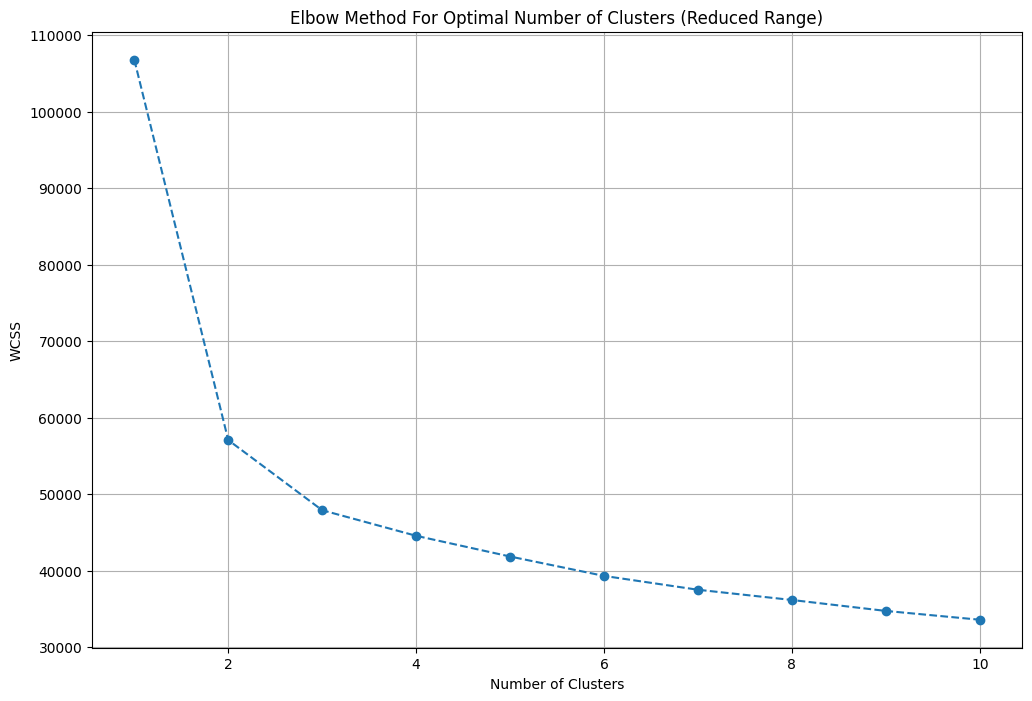

In [48]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [49]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [50]:
df = df.iloc[:,:-18]

In [51]:
df['furnishing_type'] = cluster_assignments

In [52]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
2833,NaN,0
137,NaN,0
4117,"['1 Water Purifier', '5 Fan', '1 Fridge', '1 D...",1
1800,NaN,0
1819,NaN,0


## 5.features

In [53]:
df[['society','features']].sample(5)

,society,features
4771,ushma flats,['Lift(s)']
1693,sanvicasa sparsh,"['Security / Fire Alarm', 'Feng Shui / Vaastu ..."
4150,karnavati 3,"['Feng Shui / Vaastu Compliant', 'Security / F..."
4384,rangsagar flats,NaN
1737,godrej green glades,"['Feng Shui / Vaastu Compliant', 'Security / F..."


In [54]:
df['features'].isnull().sum()

1244

In [55]:
app_df = pd.read_csv(path + 'appartments.csv')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Atithi Elegance,"2, 3 BHK Apartment in Narol, Ahmedabad East","['Rahe Public School', 'State Bank of India', ...","{'Rahe Public School': '240 WITHIN M', 'State ...",https://www.99acres.com/atithi-elegance-narol-...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Car wash area', 'Swimming Pool', 'Sun Deck',..."
1,Sattvam Icon,"2 BHK Apartment in Vatva, Ahmedabad East","['NH47', 'Aviraj Pinnacle', 'Vedant Internatio...","{'NH47': '1.6 KM', 'Aviraj Pinnacle': '3.7 K...",https://www.99acres.com/sattvam-icon-vatva-ahm...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Solar Lighting', 'Piped Gas', 'Gazebo', 'CCT..."


In [56]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [57]:
temp_df = df[df['features'].isnull()]

In [58]:
temp_df.shape

(1244, 27)

In [59]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [61]:
df.loc[temp_df.index,'features'] = x.values

In [62]:
df['features'].isnull().sum()

1220

In [63]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [64]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [65]:
features_binary_df.sample(5)

,24/7 Power Backup,24x7 Security,ATM,Airy Rooms,Amphitheatre,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Billiards,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Centrally Air Conditioned,Changing Area,Children's Play Area,Club House,Club house / Community Center,Community Hall,Creche/Day care,Cricket Pitch,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fitness Centre / GYM,Football,Gated Community,Gazebo,Gymnasium,High Ceiling Height,Indoor Games,Intercom Facility,Internet/wi-fi connectivity,Landscape Garden,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Medical Centre,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,No open drainage around,Park,Party Lawn,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Rain Water Harvesting,Recently Renovated,Reflexology Park,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Shopping Centre,Skating Rink,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Table Tennis,Temple,Theater Home,Vastu Compliant,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Storage,Water purifier,Water softening plant,Yoga/Meditation Area
1518,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
5238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5744,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,1,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,0
4159,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
2526,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [66]:
temp_features = features_binary_df.columns.to_list()

In [67]:
features_binary_df.shape

(5933, 84)

In [68]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Arpit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

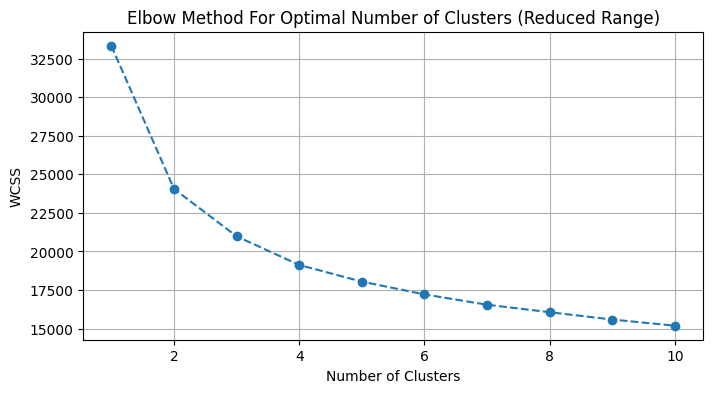

In [69]:
# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [70]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    'Airy Rooms': 9,
    'Bank Attached Property': 6,
    'Centrally Air Conditioned': 8,
    'Club house / Community Center': 7,
    'False Ceiling Lighting': 8,
    'Feng Shui / Vaastu Compliant': 7,
    'Fitness Centre / GYM': 9,
    'High Ceiling Height': 8,
    'Intercom Facility': 7,
    'Internet/wi-fi connectivity': 9,
    'Lift(s)': 9,
    'Low Density Society': 8,
    'Maintenance Staff': 6,
    'Natural Light': 9,
    'No open drainage around': 10,
    'Park': 8,
    'Piped-gas': 9,
    'Power Back-up': 9,
    'Private Garden / Terrace': 8,
    'Rain Water Harvesting': 9,
    'Recently Renovated': 7,
    'Security / Fire Alarm': 8,
    'Security Personnel': 9,
    'Separate entry for servant room': 7,
    'Shopping Centre': 8,
    'Spacious Interiors': 9,
    'Swimming Pool': 9,
    'Visitor Parking': 8,
    'Waste Disposal': 9,
    'Water Storage': 8,
    'Water purifier': 9,
    'Water softening plant': 8
}

# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [71]:
df['luxury_score'] = luxury_score

In [72]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,olive greens,gota,0.90,9313.0,966.0,Super Built up area 1918(178.19 sq.m.)Built Up...,3,3,1,store room,3.0,East,Relatively New,"['Fraucow Shopping Mall', 'S G Business Hub', ...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",L63689388,1918.0,1005.0,967.9,0,0,1,0,0,0,"[Security / Fire Alarm, Feng Shui / Vaastu Com...",165
1,house,aamramanjari bunglows,south bopal,6.40,16049.0,3988.0,Plot area 450(376.26 sq.m.)Built Up area: 600 ...,5,5,2,not available,1.0,East,Relatively New,"['Icici ATM', 'State bank of india sbi ATM', '...","['1 Water Purifier', '5 Fan', '1 Dining Table'...","['Security / Fire Alarm', 'Water Storage', 'Vi...",C69028840,NaN,600.0,NaN,0,0,0,0,0,1,"[Security / Fire Alarm, Water Storage, Visitor...",42
2,flat,avirat silver gardenia,gota,0.62,7607.0,815.0,Super Built up area 1359(126.26 sq.m.)Carpet a...,2,2,1,store room,2.0,East,Relatively New,"['CHANDLODIA MARKET', 'Bhagwat Vidyapeeth', 'v...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",C70043520,1359.0,NaN,815.0,0,0,1,0,0,0,"[Security / Fire Alarm, Feng Shui / Vaastu Com...",138
3,flat,preet residency,memnagar,0.85,5666.0,1500.0,Super Built up area 1500(139.35 sq.m.)Carpet a...,3,3,1,store room,4.0,NaN,Old Property,"['Manav Mandir', 'ambe mataa mandir', 'Axis ba...","['1 Water Purifier', '6 Fan', '1 Fridge', '1 D...","['Lift(s)', 'Maintenance Staff', 'Security Per...",I69907630,1500.0,NaN,1250.0,0,0,1,0,0,1,"[Lift(s), Maintenance Staff, Security Personne...",42
4,house,independent,south bopal,2.30,9536.0,2412.0,Plot area 268(224.08 sq.m.),3,3,1,store room,1.0,NaN,Moderately Old,"['State bank of india sbi ATM', 'Icici ATM', '...","['1 Fridge', '1 Dining Table', '1 Modular Kitc...","['Private Garden / Terrace', 'Waste Disposal']",C70391696,NaN,2412.0,NaN,0,0,1,0,0,0,"[Private Garden / Terrace, Waste Disposal]",17


In [73]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom','property_id'],inplace=True)

In [74]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
4121,flat,shukan apartment,vastrapur,0.50,6460.0,774.0,Carpet area: 86 (71.91 sq.m.),2,2,1,1.0,South-East,Old Property,NaN,NaN,86.0,0,0,0,0,0,0,8
5863,flat,hn shivalay shikhar,shilaj,0.70,4300.0,1628.0,Built Up area: 1630 (151.43 sq.m.),3,3,1,6.0,South,Relatively New,NaN,1630.0,NaN,0,0,0,1,0,0,67
5891,house,supercity glory,bhadaj,3.25,108333.0,300.0,Plot area 300(27.87 sq.m.)Carpet area: 250 sq....,3,3,2,2.0,South,Relatively New,NaN,NaN,250.0,1,0,1,1,0,0,221
2045,flat,swati residency 4,chandkheda,0.45,6502.0,692.0,Carpet area: 692 (64.29 sq.m.),2,2,3,3.0,NaN,Moderately Old,NaN,NaN,692.0,0,0,1,0,0,0,55
5917,flat,krishna residency,ghuma,0.32,3485.0,918.0,Carpet area: 918 (85.28 sq.m.),2,2,1,1.0,NaN,Moderately Old,NaN,NaN,918.0,0,0,0,0,0,2,0


In [75]:
df.shape

(5933, 23)

In [76]:
df.to_csv(out_path / 'properties_cleaned_v2.csv',index=False)